#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    X =np.asarray(X, float)
    y = np.asarray(y, float).ravel()
    w = np.asarray(w, float).ravel()
    z = y*(X@w + w0)
    data =np.log1p(np.exp(-z)).mean()
    l1 =gamma*np.abs(w).sum()
    l2 = beta*(w@w)
    return float(data+l1+l2)

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization

    '''
    X =np.asarray(X, float)
    y = np.asarray(y, float).ravel()
    w = np.asarray(w, float).ravel()
    N = X.shape[0]
    z = y*(X @ w + w0)
    s = 1.0/(1.0 + np.exp(z))
    grad_w = -(X*(y*s)[:, None]).mean(axis=0) + gamma*np.sign(w) + 2.0*beta*w
    grad_w0 = float(-(y*s).mean())
    return grad_w.tolist(), grad_w0

In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        '''
        betta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: minimal allowed movement in each iteration
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge

        '''
        self.beta =float(beta)
        self.gamma = float(gamma)
        self.lr =float(lr)
        self.tolerance =float(tolerance)
        self.max_iter = int(max_iter)
        self.random_state = random_state
        self.w = None
        self.w0 =0.0
        self.loss_history =[]

    def fit(self, X, y):
        X =np.asarray(X, float)
        y = np.asarray(y, float).ravel()
        y = np.where(y==0, -1.0, y)
        rs =np.random.RandomState(self.random_state)
        self.w =rs.normal(scale=0.01, size=X.shape[1])
        self.w0 = 0.0
        prev = np.inf
        for _ in range(self.max_iter):
            gw, gw0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
            self.w  = self.w  - self.lr*np.asarray(gw)
            self.w0 = self.w0 - self.lr*gw0
            cur = loss(X, y, self.w, self.w0, self.gamma, self.beta)
            self.loss_history.append(cur)
            if abs(prev - cur) < self.tolerance:
                break
            prev = cur
        return self


    def predict(self, X):
        '''
        Function that returns the vector of predicted labels for each object from X

        '''
        s = X @ self.w + self.w0
        return np.where(s >=0, 1,-1)


    def predict_proba(self, X):
        '''
        Function that estimates probabilities

        '''
        z= X@self.w + self.w0
        p1 = 1.0/(1.0 + np.exp(-z))
        p0= 1.0-p1
        return np.c_[p0, p1]

In [9]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [10]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(5,4))
    plt.contourf(xx, yy, zz, alpha=0.2, levels=[-1,0,1], cmap="coolwarm")
    plt.scatter(X[:,0], X[:,1], c=y, cmap="coolwarm", s=15, edgecolor="none")
    plt.show()

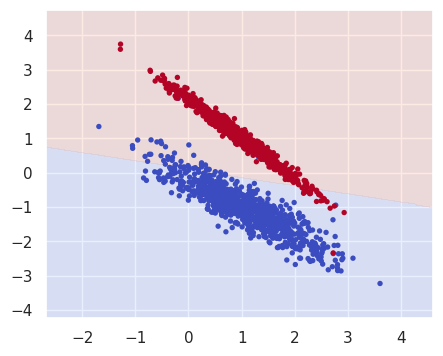

In [11]:
model = Logit(0,0)
yy = y.copy(); yy[yy==0] =-1
model.fit(X, yy)
plot_decision_boundary(model, X, yy)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [12]:
def plot_loss_history(model):
    plt.figure(figsize=(5,4))
    plt.plot(model.loss_history)
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()

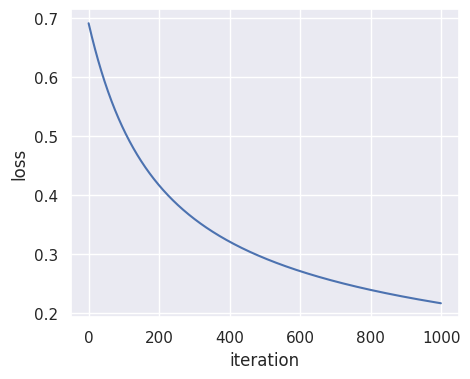

In [13]:
plot_loss_history(model)

#### 6. [1 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
import pandas as pd

C_grid = [0.5, 1, 4, 7, 11]
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
rows = []
for kernel in ("linear", "rbf", "poly"):
    for C in C_grid:
        clf = SVC(kernel=kernel, C=C, probability=True, random_state=42)
        clf.fit(Xtr, ytr)
        yp = clf.predict(Xte)
        pp = clf.predict_proba(Xte)[:, 1]
        rows.append({
            "kernel": kernel,
            "C": C,
            "acc": accuracy_score(yte, yp),
            "prec": precision_score(yte, yp),
            "rec": recall_score(yte, yp),
            "auc": roc_auc_score(yte, pp),
            "f1": f1_score(yte, yp)
        })
tbl = pd.DataFrame(rows)
tbl = tbl.sort_values(["acc","f1","auc"], ascending=False).reset_index(drop=True)
tbl = tbl.assign(acc=tbl["acc"].round(4),
                 prec=tbl["prec"].round(4),
                 rec=tbl["rec"].round(4),
                 auc=tbl["auc"].round(4),
                 f1=tbl["f1"].round(4))
tbl


,kernel,C,acc,prec,rec,auc,f1
0,rbf,0.5,0.9944,0.9926,0.9963,0.9980,0.9945
1,rbf,1.0,0.9944,0.9926,0.9963,0.9978,0.9945
2,rbf,11.0,0.9944,0.9926,0.9963,0.9965,0.9945
3,rbf,7.0,0.9944,0.9926,0.9963,0.9965,0.9945
4,poly,11.0,0.9944,0.9926,0.9963,0.9940,0.9945
5,poly,7.0,0.9944,0.9926,0.9963,0.9940,0.9945
6,poly,4.0,0.9944,0.9926,0.9963,0.9940,0.9945
7,poly,1.0,0.9944,0.9926,0.9963,0.9937,0.9945
8,poly,0.5,0.9944,0.9926,0.9963,0.9934,0.9945
9,rbf,4.0,0.9926,0.9890,0.9963,0.9965,0.9926


#### 6.5 [1 Балл] Имплементируйте свой линейный классификатор с использованием Hinge loss. Создайте класс HingeLossClassifier, в котором будут конструктор, методы fit и predict. Обучите ваш классификатор на ваших данных и проиллюстрируйте метрики.

In [15]:
class HingeLossClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=1e-2, beta=1e-3, max_iter=1000, random_state=42):
        self.lr = float(lr)
        self.beta = float(beta)
        self.max_iter = int(max_iter)
        self.random_state = random_state
        self.w = None
        self.w0 = 0.0

    def fit(self, X, y):
        X =np.asarray(X, float)
        y = np.where(y==0,-1,1).astype(float)
        rs =np.random.RandomState(self.random_state)
        self.w = rs.normal(scale=0.01, size=X.shape[1])
        self.w0 =0.0
        for _ in range(self.max_iter):
            margin = y*(X @ self.w+self.w0)
            mis = margin <1.0
            if np.any(mis):
                gw =-(X[mis]*y[mis, None]).mean(axis=0) + 2*self.beta*self.w
                gb = -(y[mis]).mean()
            else:
                gw = 2*self.beta*self.w
                gb =0.0
            self.w -=self.lr*gw
            self.w0 -= self.lr*gb
        return self

    def predict(self, X):
        return np.where(X@self.w + self.w0 >=0,1,-1)


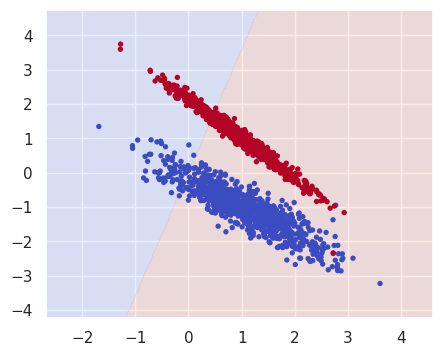

In [16]:
model = HingeLossClassifier(0,0)
yy = y.copy(); yy[yy==0] =-1
model.fit(X, yy)
plot_decision_boundary(model, X, yy)

#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [17]:
class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        assert metric == 'euclidean'
        self.k = int(n_neighbors)
        self.X = None
        self.y = None
        self.classes_ = None

    def fit(self, X, y):
        self.X = np.asarray(X, float)
        self.y = np.asarray(y)
        self.classes_ = np.unique(self.y)
        return self

    def predict(self, X):
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]

    def predict_proba(self, X):
        X = np.asarray(X, float)
        qn = np.sum(X*X, axis=1, keepdims=True)
        tn = np.sum(self.X*self.X, axis=1)[None, :]
        d2 = qn + tn - 2.0 * (X @ self.X.T)
        idx = np.argpartition(d2, self.k-1, axis=1)[:, :self.k]
        neigh_y = self.y[idx]
        proba = []
        for row in neigh_y:
            counts = [(row==c).mean() for c in self.classes_]
            proba.append(counts)
        return np.asarray(proba, float)

In [18]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

clf = KNNClassifier(n_neighbors=5).fit(Xtr, ytr)
yp = clf.predict(Xte)
pp = clf.predict_proba(Xte)
pos_col = np.where(clf.classes_ == clf.classes_.max())[0][0]
metrics = {
    "Acc":  accuracy_score(yte, yp),
    "Prec": precision_score(yte, yp, average="binary" if len(clf.classes_)==2 else "macro"),
    "Rec":  recall_score(yte, yp, average="binary" if len(clf.classes_)==2 else "macro"),
    "AUC":  roc_auc_score(yte, pp[:, pos_col]) if len(clf.classes_)==2 else roc_auc_score(yte, pp, multi_class="ovr"),
    "F1":   f1_score(yte, yp, average="binary" if len(clf.classes_)==2 else "macro"),
}
pd.DataFrame([metrics]).round(4)

,Acc,Prec,Rec,AUC,F1
0,0.9926,0.989,0.9963,0.9944,0.9926


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
TRAIN_CSV = "C:/Users/ASUS/Downloads/Telegram Desktop/fashion-mnist_train.csv/fashion-mnist_train.csv"
TEST_CSV  = "C:/Users/ASUS/Downloads/Telegram Desktop/fashion-mnist_test.csv/fashion-mnist_test.csv"

train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

y_train = train_df.iloc[:, 0].values
X_train = train_df.iloc[:, 1:].values.astype(float)
if test_df.shape[1] == train_df.shape[1]:
    y_test = test_df.iloc[:, 0].values
    X_test = test_df.iloc[:, 1:].values.astype(float)
else:
    y_test = None
    X_test = test_df.values.astype(float)

X_train.shape, X_test.shape, (None if y_test is None else y_test.shape)


((60000, 784), (10000, 784), (10000,))

#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

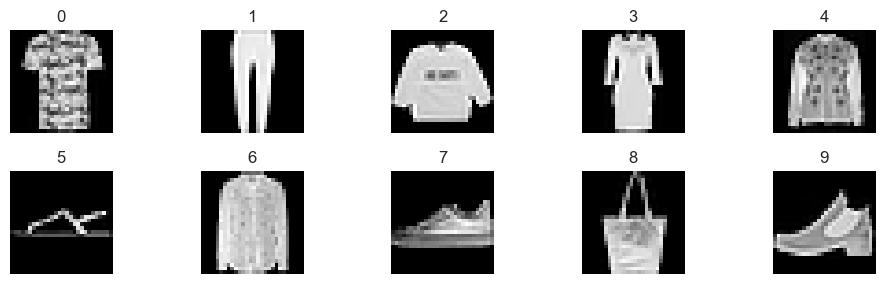

In [ ]:
labels = np.unique(y_train)
plt.figure(figsize=(10,3))
for i,l in enumerate(labels[:10]):
    img = X_train[y_train==l][0].reshape(28,28)
    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(int(l)); plt.axis("off")
plt.tight_layout(); plt.show()


#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

std_scaler = StandardScaler()
mm_scaler  = MinMaxScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std  = std_scaler.transform(X_test)
X_train_mm  = mm_scaler.fit_transform(X_train)
X_test_mm   = mm_scaler.transform(X_test)


In [ ]:
print("StandardScaler:")
print("  train mean =", np.round(X_train_std.mean(axis=0).mean(), 4), " train std =", np.round(X_train_std.std(axis=0).mean(), 4))
print("  shapes:", X_train_std.shape, X_test_std.shape)

print("\nMinMaxScaler:")
print("  train min =", np.round(X_train_mm.min(axis=0).mean(), 4), " train max =", np.round(X_train_mm.max(axis=0).mean(), 4))
print("  shapes:", X_train_mm.shape, X_test_mm.shape)

StandardScaler:
  train mean = -0.0  train std = 1.0
  shapes: (60000, 784) (10000, 784)

MinMaxScaler:
  train min = 0.0  train max = 1.0
  shapes: (60000, 784) (10000, 784)


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

if 'X_train' in globals() and 'X_test' in globals() and 'y_train' in globals() and 'y_test' in globals():
    Xtr, Xte, ytr, yte = X_train, X_test, y_train, y_test
else:
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

N_SUB = min(10000, len(Xtr))
idx = np.random.default_rng(42).choice(len(Xtr), size=N_SUB, replace=False)
Xsub, ysub = Xtr[idx], ytr[idx]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# быстрый KNN
pipe_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])
grid_knn = {
    "clf__n_neighbors": [3, 5, 9],
    "clf__weights": ["uniform"],
    "clf__p": [2],
}
gs_knn = GridSearchCV(pipe_knn, grid_knn, scoring="accuracy", cv=cv, n_jobs=-1, verbose=0)
gs_knn.fit(Xsub, ysub)
knn_best = gs_knn.best_estimator_
knn_acc = accuracy_score(yte, knn_best.predict(Xte))

# быстрый LogisticRegression
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, solver="lbfgs", n_jobs=-1))
])
grid_lr = {
    "clf__penalty": ["l2"],
    "clf__C": [0.1, 1, 10],
    "clf__class_weight": [None, "balanced"],
}
gs_lr = GridSearchCV(pipe_lr, grid_lr, scoring="accuracy", cv=cv, n_jobs=-1, verbose=0)
gs_lr.fit(Xsub, ysub)
lr_best = gs_lr.best_estimator_
lr_acc = accuracy_score(yte, lr_best.predict(Xte))

res = pd.DataFrame([
    {"model":"KNN", "cv_best_acc":round(gs_knn.best_score_,4), "test_acc":round(knn_acc,4), "best_params":gs_knn.best_params_},
    {"model":"LogReg", "cv_best_acc":round(gs_lr.best_score_,4), "test_acc":round(lr_acc,4), "best_params":gs_lr.best_params_},
]).sort_values("test_acc", ascending=False).reset_index(drop=True)
res


,model,cv_best_acc,test_acc,best_params
0,LogReg,0.8240,0.8307,"{'clf__C': 0.1, 'clf__class_weight': None, 'cl..."
1,KNN,0.8107,0.8177,"{'clf__n_neighbors': 9, 'clf__p': 2, 'clf__wei..."


# KNN
n_neighbors это главный регулятор сложности модели то есть маленькое k даёт низкий bias и высокий variance, большое k сглаживает (выше bias, ниже variance). Чтобы найти баланс подбирал по сетке. weights = {uniform, distance} взвешивание по расстоянию уменьшает влияние дальних соседей и повышает качество при пересечении классов. p = {1, 2} есть метрика расстояния L1 может быть устойчивее в высоких размерностях, L2 -стандартный выбор. Скейлинг признаков standardScaler/mnMaxScaler критичен для моделей на расстояниях чтобы признаки были сопоставимы по масштабу.
# Логистическая регрессия
L2 стабилизирует веса и хорошо работает при мультиколлинеарности. L1 даёт разреженность то есть встроенная селекция признаков. ElasticNet балансирует на обе подбирал l1_ratio. C сила регуляризации обратная коэффициенту штрафа. Логарифмическая сетка покрывает режимы от сильного штрафа до его отсутствия. class_weight = {None, balanced} на случай дисбаланса классов, чтобы не терять accuracy по меньшинству.Скейлинг ускоряет сходимость и делает регуляризацию сопоставимой по осям признаков.
# Вывод
У модели Логистической регрессии test accuracy больше чем у KNN, поэтому логистическая регрессия лучше, но так как разница небольшая порядка 0.02 можно сказать что модели сопоставимы.

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

Если все объекты идентичны по признаками, и классы сбалансированы 5000/5000. логистическая регрессия на SGD придёт к w≈0, w0≈0, то есть градиенты симметрично взаимно удаляются. Предсказания p≈0.5 для всех accuracy≈0.5 и регуляризация не меняет вывода"